In [1]:
# script to obtain the oscillating atoms using a vanilla verlet Integrator
# The main idea is to build a reference model to study the behavior fo the
# Neural network accelerated Molecular dynamic.

# we use the modelscf to compute the forces, and the velocity verlet algorithm
# to evolve the system.

# in this case we save the evolution of the system in a hd5f file.

include("../src/Atoms.jl")
include("../src/scfOptions.jl")
include("../src/anderson_mix.jl")
include("../src/kerker_mix.jl")
include("../src/Ham.jl")
include("../src/hartree_pot_bc.jl")
include("../src/pseudocharge.jl")
include("../src/getocc.jl")
include("../src/Integrators.jl")

# flag to save the data

# number of MD simulations and
Nit = 200

# getting all the parameters
dx = 0.5;
Nunit = 8;   # number of units
Lat = 10;     # size of the lattice
Ls = Nunit*Lat;
Ns = round(Integer, Ls / dx); # number of discretization points

# using the default values in Lin's code
YukawaK = 0.0100
n_extra = 10;
epsil0 = 10.0;
T_elec = 100.0;

kb = 3.1668e-6;
au2K = 315774.67;
Tbeta = au2K / T_elec;

betamix = 0.5;
mixdim = 10;

Ndist = 1;
Natoms = round(Integer, Nunit / Ndist);

sigma  = ones(Natoms,1)*(1.0);  # insulator
omega  = ones(Natoms,1)*0.03;
Eqdist = ones(Natoms,1)*10.0;
mass   = ones(Natoms,1)*42000.0;
nocc   = ones(Natoms,1)*2;          # number of electrons per atom
Z      = nocc;

function forces(x::Array{Float64,1})
    # input
    #       x: vector with the position of the atoms
    # output
    #       f: forces at the center of the atoms

    R = reshape(x, length(x), 1) # we need to make it a two dimensional array
    # creating an atom structure
    atoms = Atoms(Natoms, R, sigma,  omega,  Eqdist, mass, Z, nocc);
    # allocating a Hamiltonian
    ham = Ham(Lat, Nunit, n_extra, dx, atoms,YukawaK, epsil0, Tbeta)

    # total number of occupied orbitals
    Nocc = round(Integer, sum(atoms.nocc) / ham.nspin);

    # setting the options for the scf iteration
    mixOpts = andersonMixOptions(ham.Ns, betamix, mixdim )
    eigOpts = eigOptions(1.e-10, 1000, "eig");
    scfOpts = scfOptions(1.e-8, 300, eigOpts, mixOpts)

    # initialize the potentials within the Hemiltonian, setting H[\rho_0]
    init_pot!(ham, Nocc)

    # running the scf iteration
    VtoterrHist = scf!(ham, scfOpts)

    if VtoterrHist[end] > scfOpts.SCFtol
        println("convergence not achieved!! ")
    end

    # we compute the forces
    get_force!(ham)

    # computing the energy
    Vhar = hartree_pot_bc(ham.rho+ham.rhoa,ham);

    # NOTE: ham.Fband is only the band energy here.  The real total energy
    # is calculated using the formula below:
    Etot = ham.Eband + 1/2*sum((ham.rhoa-ham.rho).*Vhar)*dx;

    return ham.atoms.force[:]
end

# Setting the time evolution
dt = 1.0

x0 = zeros(Natoms); # this is defined as an 2D array
for j = 1:Natoms
  x0[j] = (j-0.5)*Lat*Ndist+dx;
end

x0[1] = x0[1] + 1.0

v0 = zeros(Natoms)
x1 = x0 + dt*v0

#### Computing the trajectories

(X_traj, v, vdot) = time_evolution(velocity_verlet, x -> forces(x), dt, Nit, x0, x1)

Rho    = zeros(Ns, Nit)
Etotal = zeros(1, Nit)
Ftotal = zeros(Natoms, Nit)


# we re-run the DFT computation using the trajectory
for ii = 1:Nit

    # we use the data of the evolved function
    R = reshape(X_traj[ii, :],Natoms,1)

    # creating an atom structure
    atoms = Atoms(Natoms, R, sigma,  omega,  Eqdist, mass, Z, nocc);

    # allocating a Hamiltonian
    ham = Ham(Lat, Nunit, n_extra, dx, atoms,YukawaK, epsil0, Tbeta)

    # total number of occupied orbitals
    Nocc = round(Integer, sum(atoms.nocc) / ham.nspin);

    # initialize the potentials within the Hemiltonian, setting H[\rho_0]
    init_pot!(ham, Nocc)

    # we use the anderson mixing of the potential
    mixOpts = andersonMixOptions(ham.Ns, betamix, mixdim )

    # we use the default options
    eigOpts = eigOptions(1.e-12, 1000, "eig");

    scfOpts = scfOptions(1.e-10, 3000, eigOpts, mixOpts)

    # running the scf iteration
    @time VtoterrHist = scf!(ham, scfOpts)

    # we compute the forces
    get_force!(ham)

    # computing the energy
    Vhar = hartree_pot_bc(ham.rho+ham.rhoa,ham);

    # NOTE: ham.Fband is only the band energy here.  The real total energy
    # is calculated using the formula below:
    Etot = ham.Eband + 1/2*sum((ham.rhoa-ham.rho).*Vhar)*dx;

    Etotal[ii] = Etot
    Ftotal[:,ii] = ham.atoms.force[:]
    Rho[:,ii] = ham.rho[:];

    println(length(VtoterrHist))
end

print("simulation finished")

initial conditions
running the loop
loop finished
  0.523032 seconds (18.45 k allocations: 143.125 MiB, 3.09% gc time)
37
  0.533554 seconds (18.94 k allocations: 146.996 MiB, 3.38% gc time)
38
  0.504439 seconds (17.66 k allocations: 139.156 MiB, 2.54% gc time)
36
  0.518736 seconds (18.15 k allocations: 143.028 MiB, 2.93% gc time)
37
  0.506736 seconds (17.80 k allocations: 139.201 MiB, 2.56% gc time)
36
  0.516717 seconds (18.29 k allocations: 143.073 MiB, 2.86% gc time)
37
  0.476931 seconds (16.64 k allocations: 131.401 MiB, 2.68% gc time)
34
  0.489232 seconds (17.24 k allocations: 135.310 MiB, 2.64% gc time)
35
  0.494444 seconds (17.11 k allocations: 135.267 MiB, 2.64% gc time)
35
  0.505558 seconds (17.25 k allocations: 135.312 MiB, 2.61% gc time)
35
  0.514561 seconds (17.24 k allocations: 135.309 MiB, 2.82% gc time)
35
  0.509836 seconds (17.09 k allocations: 135.261 MiB, 2.89% gc time)
35
  0.493166 seconds (17.09 k allocations: 135.262 MiB, 2.59% gc time)
35
  0.511290 sec

  0.484094 seconds (16.67 k allocations: 131.411 MiB, 2.62% gc time)
34
  0.461215 seconds (15.68 k allocations: 123.664 MiB, 2.75% gc time)
32
  0.478160 seconds (16.52 k allocations: 131.364 MiB, 2.38% gc time)
34
  0.461654 seconds (16.18 k allocations: 127.538 MiB, 2.56% gc time)
33
  0.475303 seconds (16.67 k allocations: 131.412 MiB, 2.49% gc time)
34
  0.458340 seconds (16.02 k allocations: 127.488 MiB, 2.17% gc time)
33
  0.445393 seconds (15.68 k allocations: 123.664 MiB, 2.72% gc time)
32
  0.459319 seconds (15.68 k allocations: 123.664 MiB, 2.56% gc time)
32
  0.470064 seconds (16.17 k allocations: 127.538 MiB, 2.18% gc time)
33
  0.469866 seconds (16.17 k allocations: 127.538 MiB, 2.54% gc time)
33
  0.486289 seconds (16.53 k allocations: 131.365 MiB, 2.55% gc time)
34
  0.468699 seconds (16.02 k allocations: 127.488 MiB, 2.65% gc time)
33
  0.485117 seconds (16.51 k allocations: 131.361 MiB, 2.33% gc time)
34
  0.484519 seconds (16.67 k allocations: 131.411 MiB, 2.44% gc t

In [2]:
X_traj

201×8 Array{Float64,2}:
 6.5      15.5     25.5     35.5     45.5     55.5     65.5     75.5   
 6.49918  15.5006  25.5     35.5     45.5     55.5     65.5     75.5002
 6.49671  15.5025  25.5     35.5     45.5     55.5     65.5     75.5008
 6.49262  15.5055  25.5     35.5     45.5     55.5     65.5     75.5019
 6.48691  15.5097  25.5     35.5     45.5     55.5     65.5     75.5033
 6.4796   15.5152  25.5     35.5     45.5     55.5     65.5     75.5052
 6.47073  15.5217  25.5001  35.5     45.5     55.5     65.5     75.5075
 6.46031  15.5294  25.5001  35.5     45.5     55.5     65.5     75.5101
 6.4484   15.5382  25.5002  35.5     45.5     55.5     65.5001  75.5132
 6.43504  15.548   25.5002  35.5     45.5     55.5     65.5001  75.5167
 6.42026  15.5587  25.5004  35.5     45.5     55.5     65.5001  75.5205
 6.40412  15.5704  25.5005  35.5     45.5     55.5     65.5002  75.5248
 6.38667  15.583   25.5007  35.5     45.5     55.5     65.5002  75.5294
 ⋮                                      

In [3]:
Etotal

1×200 Array{Float64,2}:
 4.06071  4.06071  4.0607  4.06069  …  4.06036  4.06035  4.06033  4.06031

In [4]:
Ftotal

8×200 Array{Float64,2}:
 -0.00164428   -0.00164116   -0.00163186   …   0.00066172    0.000659375
  0.00122679    0.0012235     0.00121365      -0.000583762  -0.000575348
  3.84282e-7    8.01813e-7    2.0533e-6        0.000522854   0.000506886
 -1.51814e-8   -1.48675e-8   -1.36719e-8      -0.000100976  -9.55714e-5 
 -8.99772e-10  -9.01828e-10  -9.34375e-10     -0.000508759  -0.000486422
 -4.8674e-9    -4.75563e-9   -4.35938e-9   …   0.000324917   0.000317746
  1.4828e-7     2.90204e-7    7.15361e-7       0.0002122     0.000188944
  0.000416976   0.000416595   0.000415453     -0.000528195  -0.000515609

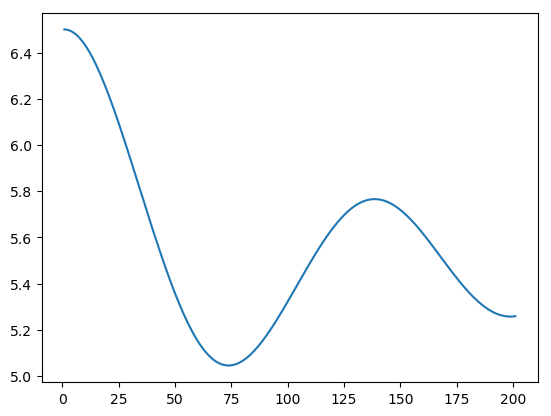

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1308916a0>

In [6]:
using PyPlot
plot(1:201, X_traj[:,1])

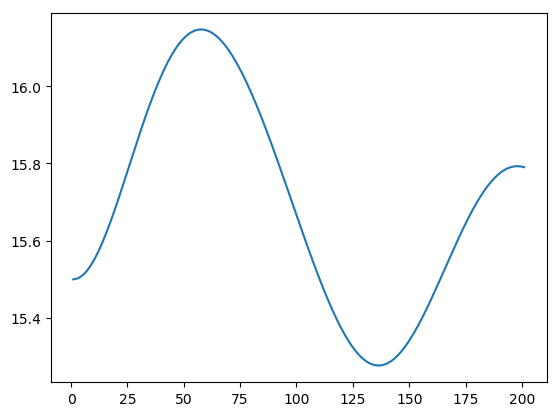

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x147f2cd30>

In [7]:
plot(1:201, X_traj[:,2])